# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Pull & Clean Brent Oil Futures Data

In [2]:
# Load all sheets into a dictionary of DataFrames
file_path = "Crude Oil Brent Raw Data.xlsx"
sheets_dict = pd.read_excel(file_path, sheet_name=None)

In [3]:
def clean_single_contract(df):
    df = df.iloc[0:65, 1:10]  # B2:J66
    df = df.rename(columns=df.iloc[0])
    df = df.drop(0)
    df['Date'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.drop('Time', axis=1) 
    df = df[['Date'] + df.columns.tolist()[:-1]]
    df = df.dropna(subset=['Date'])
    return df

In [4]:
cleaned_months = {}

for name, raw_df in sheets_dict.items():
    try:
        cleaned = clean_single_contract(raw_df)
        cleaned['Contract'] = name
        cleaned_months[name] = cleaned
    except Exception as e:
        print(f"Error processing {name}: {e}")

In [5]:
# 1) Sort each DataFrame by Date descending and reset its index to 0…64
for name, df in cleaned_months.items():
    df.sort_values("Date", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [6]:
# Drop 1999 data for now
try:
    del cleaned_months['Dec 99 (CBZ99)']
except KeyError:
    pass

## Pull Brent Oil Spot Prices

In [7]:
# Step 1: Load the CSV
market_df = pd.read_csv("EIA Europe Brent Spot Price.csv")

# Step 2: Rename columns to something simple
market_df.columns = ["Date", "BrentSpot"]

# Step 3: Convert Date to datetime format
market_df["Date"] = pd.to_datetime(market_df["Date"], format="%b %d, %Y")

# Step 4: Sort and filter relevant date range (matching your spread data)
market_df = market_df.sort_values("Date")

# Step 5: Compute daily returns
market_df["MarketReturn"] = market_df["BrentSpot"].pct_change(fill_method=None)
market_df = market_df.dropna()

In [8]:
all_spreads

NameError: name 'all_spreads' is not defined

In [ ]:
market_df

,Date,BrentSpot,MarketReturn
1,1987-05-21,18.45,-0.009662
2,1987-05-22,18.55,0.005420
3,1987-05-25,18.60,0.002695
4,1987-05-26,18.63,0.001613
5,1987-05-27,18.60,-0.001610
...,...,...,...
9641,2025-05-20,66.93,0.010264
9642,2025-05-21,65.86,-0.015987
9643,2025-05-22,64.87,-0.015032
9644,2025-05-23,65.41,0.008324


# Build Calendar Spreads

In [ ]:
# Step 1: Get contract names
contract_names = list(cleaned_months.keys())[1:]

# Step 2: Initialize empty list to hold all spreads
spread_points = []

# Step 2: Iterate through each month-pair (March–April, April–May, etc.)
for i in range(len(contract_names) - 2):
    t1 = contract_names[i + 1]  # t+1
    t2 = contract_names[i + 2]  # t+2

    df1 = cleaned_months[t1]
    df2 = cleaned_months[t2]

    # Get month t
    target_month = i % 12 + 1

    # Filter to the target month (e.g., February)
    df1_month = df1[df1["Date"].dt.month == target_month]
    df2_month = df2[df2["Date"].dt.month == target_month]

    # Inner-join on actual dates
    merged = pd.merge(
        df1_month[["Date", "Last"]],
        df2_month[["Date", "Last"]],
        on="Date",
        how="inner",
        suffixes=("_T1", "_T2")
    )

    if merged.empty:
        continue

    # Compute spread: T+2 - T+1
    merged["Spread"] = merged["Last_T1"] - merged["Last_T2"]
    spread_points.append(merged[["Date", "Spread"]])

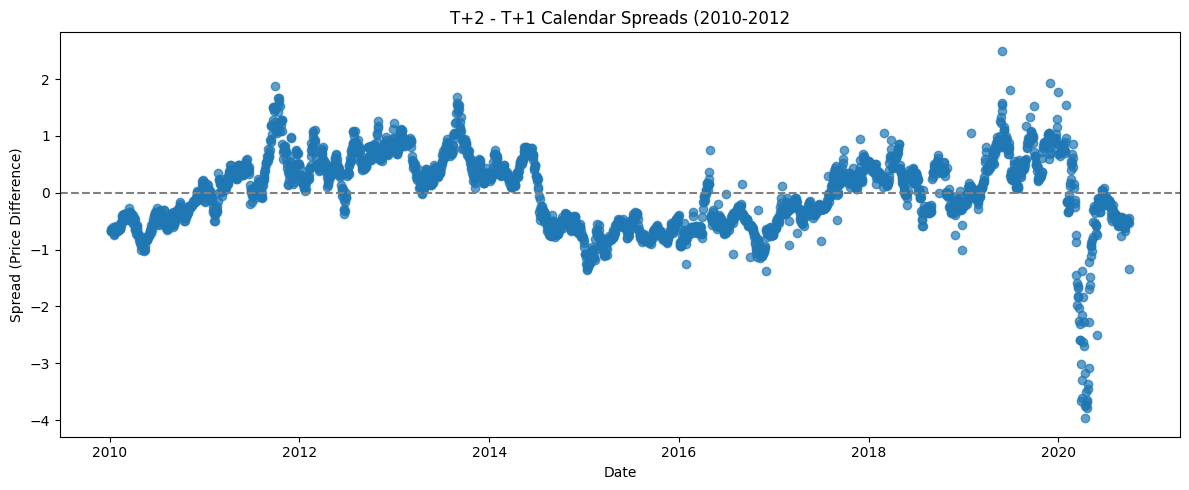

In [ ]:
# Step 4: Combine all spread points into one DataFrame
all_spreads = pd.concat(spread_points, ignore_index=True)

# Step 5: Plot
plt.figure(figsize=(12, 5))
plt.scatter(all_spreads["Date"], all_spreads["Spread"], alpha=0.7)
plt.title("T+2 - T+1 Calendar Spreads (2010-2012")
plt.xlabel("Date")
plt.ylabel("Spread (Price Difference)")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

# Build AR(1) Model

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 4.747e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:20:41   Log-Likelihood:                 1183.8
No. Observations:                2768   AIC:                            -2364.
Df Residuals:                    2766   BIC:                            -2352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0005      0.003     -0.150      

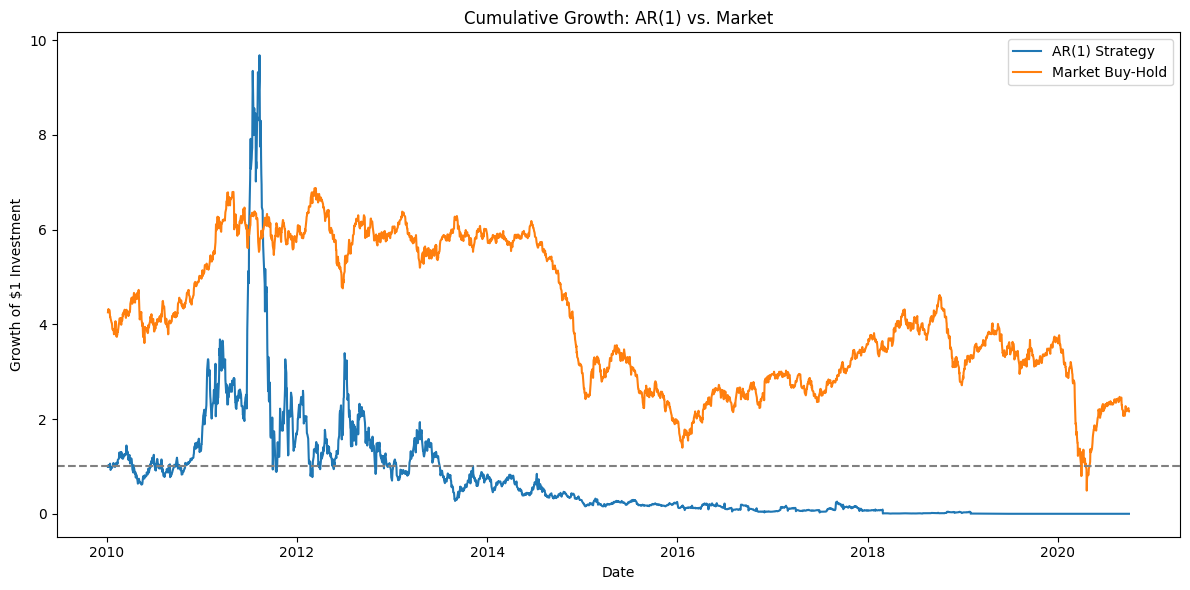

In [ ]:
# --- 1) Prepare & clean the spread series ---
df = all_spreads.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()
df["Spread_lag1"] = pd.to_numeric(df["Spread"].shift(1), errors="coerce")
df["Spread"]      = pd.to_numeric(df["Spread"],   errors="coerce")
df = df.dropna(subset=["Spread","Spread_lag1"])

# --- 2) Fit AR(1) & get in-sample forecast ---
X = sm.add_constant(df["Spread_lag1"])
ar1 = sm.OLS(df["Spread"], X).fit()
df["Spread_pred_ar1"] = ar1.predict(X)
print(ar1.summary())

# --- 3) Build a simple trading signal & P&L ---
#    +1 if forecast > yesterday’s spread, else −1
df["signal_ar1"] = np.where(df["Spread_pred_ar1"] > df["Spread_lag1"], 1, -1)
df["ret_ar1"]    = df["signal_ar1"] * (df["Spread"] - df["Spread_lag1"])
#    cumulative growth (starting at 1)
df["cum_ar1"]    = (1 + df["ret_ar1"]).cumprod()

# --- 4) Prepare the market cumulative growth ---
mkt = market_df.copy()
mkt["Date"] = pd.to_datetime(mkt["Date"])
mkt = mkt.set_index("Date").sort_index()
mkt["MarketReturn"] = pd.to_numeric(mkt["MarketReturn"], errors="coerce")
mkt = mkt.dropna(subset=["MarketReturn"])
mkt["cum_mkt"] = (1 + mkt["MarketReturn"]).cumprod()

# --- 5) Align & plot both equity curves ---
joint = pd.DataFrame({
    "AR(1) Strategy": df["cum_ar1"],
    "Buy-Hold Market": mkt["cum_mkt"]
}).dropna()

plt.figure(figsize=(12,6))
plt.plot(joint.index, joint["AR(1) Strategy"],    label="AR(1) Strategy")
plt.plot(joint.index, joint["Buy-Hold Market"],   label="Market Buy-Hold")
plt.axhline(1, color="gray", linestyle="--")  # 100% base
plt.title("Cumulative Growth: AR(1) vs. Market")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.tight_layout()
plt.show()

## Build AR(p) Models

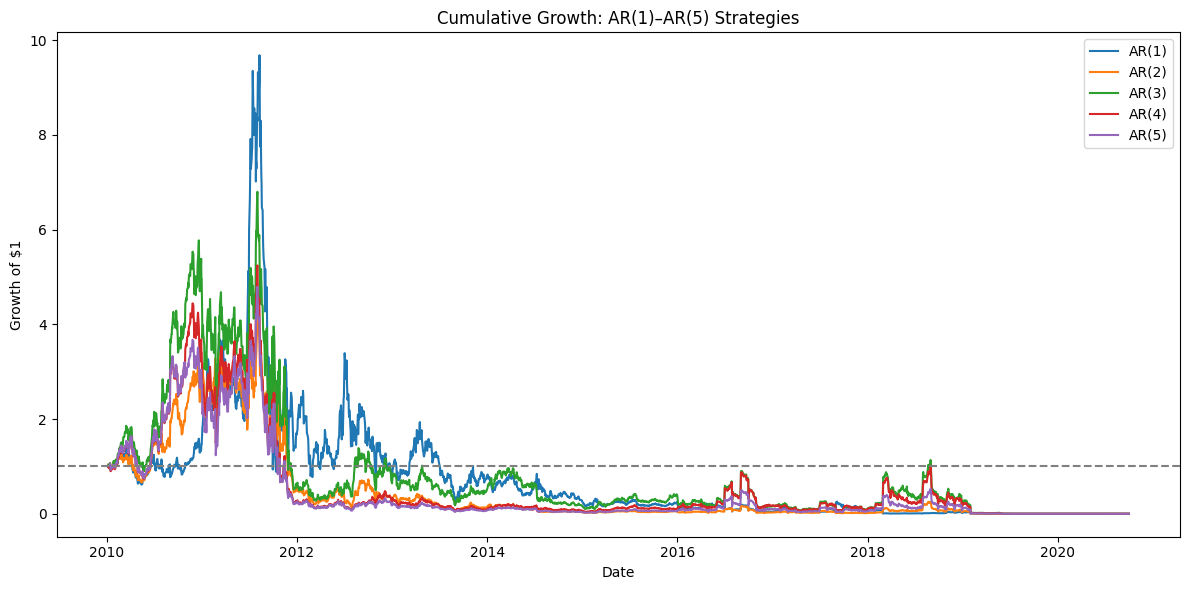

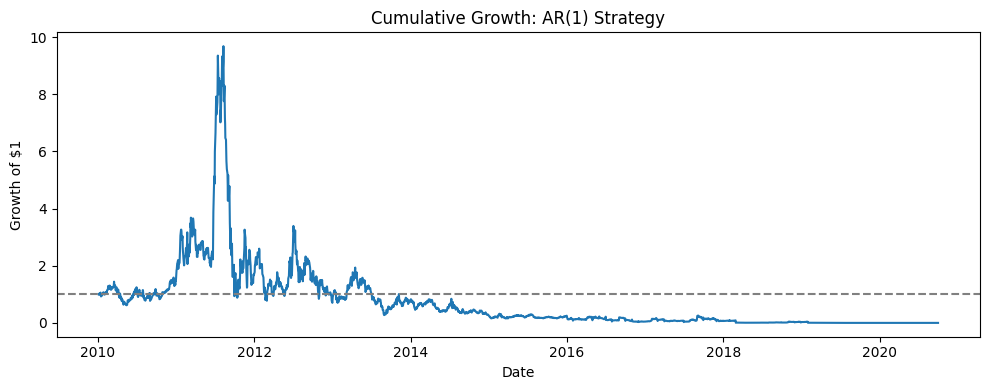

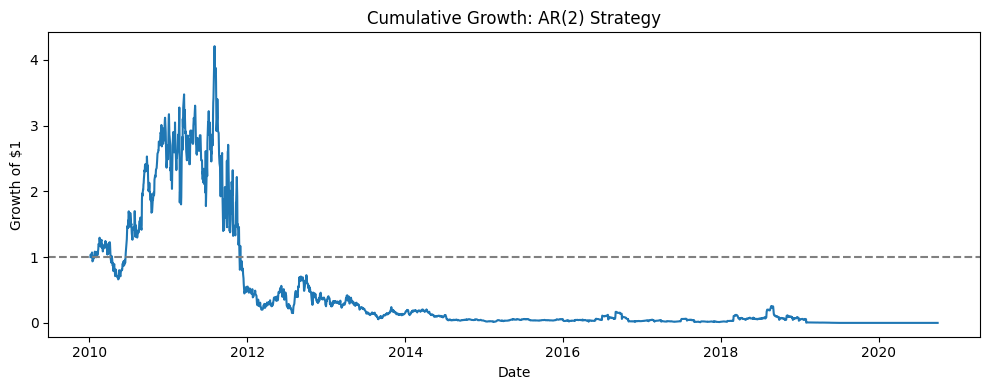

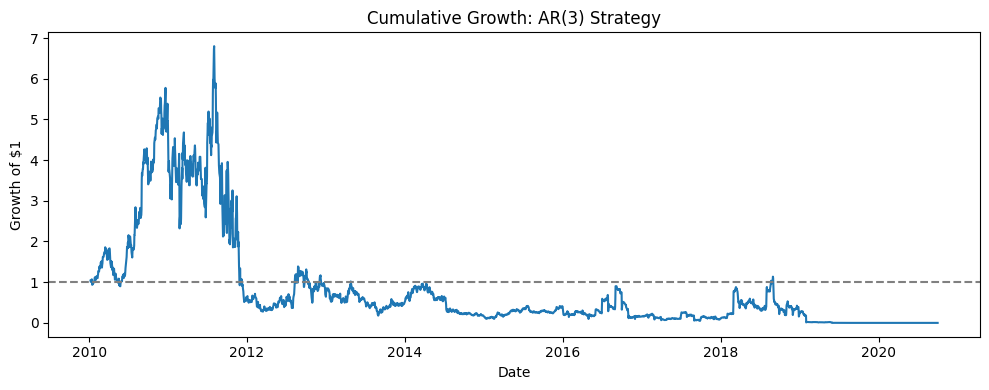

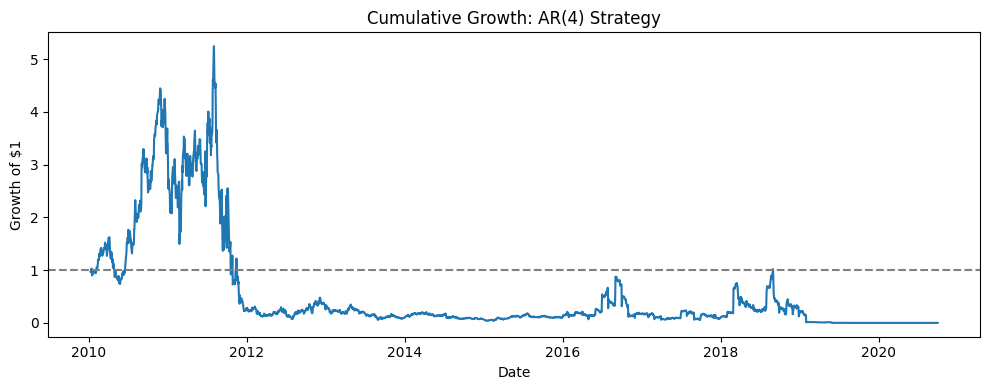

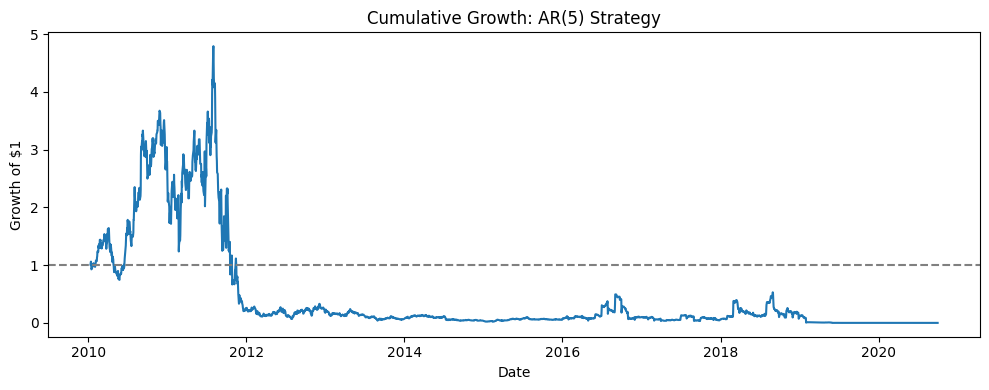

In [ ]:
# Prepare the spread series
df0 = all_spreads.copy()
df0["Date"] = pd.to_datetime(df0["Date"])
df0 = df0.set_index("Date").sort_index()
df0["Spread"] = pd.to_numeric(df0["Spread"], errors="coerce")
df0 = df0.dropna(subset=["Spread"])

# Dictionary to hold each AR(p) dataframe
ar_dfs = {}

for p in range(1, 6):
    df = df0.copy()
    # create lags 1…p
    for lag in range(1, p+1):
        df[f"lag{lag}"] = df["Spread"].shift(lag)
    df = df.dropna(subset=[f"lag{lag}" for lag in range(1, p+1)] + ["Spread"])
    
    # fit AR(p): Spread_t = α + β1⋅lag1 + … + βp⋅lagp
    X = sm.add_constant(df[[f"lag{lag}" for lag in range(1, p+1)]])
    model = sm.OLS(df["Spread"], X).fit()
    
    # one‐step forecast and simple long/short signal
    df[f"pred_ar{p}"] = model.predict(X)
    df[f"signal_ar{p}"] = np.where(
        df[f"pred_ar{p}"] > df["lag1"], 
        +1, 
        -1
    )
    
    # P&L = signal × daily change in spread
    df[f"ret_ar{p}"] = df[f"signal_ar{p}"] * (df["Spread"] - df["lag1"])
    
    # cumulative “growth” from $1
    # note: here ret_ar is a price‐difference, not a percentage,
    # so we don’t divide by 100. pct_change() already yields decimals.
    df[f"cum_ar{p}"] = (1 + df[f"ret_ar{p}"]).cumprod()
    
    ar_dfs[p] = df

# — Plot all AR curves on one chart —
plt.figure(figsize=(12,6))
for p, df in ar_dfs.items():
    plt.plot(df.index, df[f"cum_ar{p}"], label=f"AR({p})")
plt.axhline(1, color="gray", linestyle="--")
plt.legend()
plt.title("Cumulative Growth: AR(1)–AR(5) Strategies")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.tight_layout()
plt.show()

# — Plot each AR(p) individually —
for p, df in ar_dfs.items():
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df[f"cum_ar{p}"], label=f"AR({p})")
    plt.axhline(1, color="gray", linestyle="--")
    plt.title(f"Cumulative Growth: AR({p}) Strategy")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.tight_layout()
    plt.show()


# Calculating Alpha of Benchmark

In [ ]:
# compute daily spread returns
# --- 1) Prepare & clean the spread series ---
spread_ret = all_spreads.copy()
spread_ret["Date"] = pd.to_datetime(spread_ret["Date"])
spread_ret = spread_ret.set_index("Date").sort_index()
spread_ret["Spread_lag1"] = pd.to_numeric(spread_ret["Spread"].shift(5), errors="coerce")
spread_ret["Spread"]      = pd.to_numeric(spread_ret["Spread"],   errors="coerce")
spread_ret = spread_ret.dropna(subset=["Spread","Spread_lag1"])

# --- 2) Fit AR(1) & get in-sample forecast ---
X = sm.add_constant(spread_ret["Spread_lag1"])
ar1 = sm.OLS(spread_ret["Spread"], X).fit()
spread_ret["Spread_pred_ar1"] = ar1.predict(X)

# --- 3) Build a simple trading signal & P&L ---
#    +1 if forecast > yesterday’s spread, else −1
spread_ret["signal_ar1"] = np.where(spread_ret["Spread_pred_ar1"] > spread_ret["Spread_lag1"], 1, -1)
spread_ret["ret_ar1"]    = spread_ret["signal_ar1"] * (spread_ret["Spread"] - spread_ret["Spread_lag1"])

# 2) Load S&P GSCI Energy, enforce YYYY-MM-DD dates
energy = pd.read_csv("S&P GSCI Energy Data.csv")
energy["Date"] = pd.to_datetime(energy["Date"], format='%m/%d/%Y %H:%M:%S', errors="coerce").dt.normalize()
energy = energy.dropna(subset=["Date", "Close"])
energy["Close"] = pd.to_numeric(energy["Close"], errors="coerce")
energy = energy.set_index("Date").sort_index()
energy["energy_ret"] = energy["Close"].pct_change()
energy_ret = energy[["energy_ret"]].dropna()

# 3) Load Treasury yields, enforce YYYY-MM-DD dates
yld = pd.read_csv("yield-curve-rates-1990-2023.csv")
yld["Date"] = pd.to_datetime(yld["Date"], format="%m/%d/%y", errors="coerce")
yld = yld.dropna(subset=["Date", "1 Mo"])
yld["1 Mo"] = pd.to_numeric(yld["1 Mo"], errors="coerce")
yld = yld.set_index("Date").sort_index()
yld["RF"] = yld["1 Mo"] / 100.0 / 252.0
yld = yld[["RF"]]

# --- 4) Merge all three series on Date ---
df = (spread_ret
      .join(energy_ret, how="inner")
      .join(yld["RF"], how="inner")
      .dropna()
)

# --- 5) Compute excess returns ---
df["SpreadExcess"] = df["ret_ar1"] - df["RF"]
df["EnergyExcess"] = df["energy_ret"] - df["RF"]

# --- 6) Run the regression SpreadExcess ~ 1 + EnergyExcess ---
X = sm.add_constant(df["EnergyExcess"])
y = df["SpreadExcess"]
model = sm.OLS(y, X).fit()
print(model.summary())

# --- 7) Print α (daily) --
alpha_daily   = model.params["const"]
print(f"Estimated daily α:      {alpha_daily:f}")


                            OLS Regression Results                            
Dep. Variable:           SpreadExcess   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     29.03
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           7.75e-08
Time:                        23:00:02   Log-Likelihood:                -292.86
No. Observations:                2673   AIC:                             589.7
Df Residuals:                    2671   BIC:                             601.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0208      0.005      3.989   